# Characteristics of a CCD: Image Reduction

This notebook carries out the pre-processing, calibration and analysis of imaging data taken with the DFM 0.8m telescope at the UVic observatory. 

## Setup

The following two code cells import the material you will need for this lab: first the Python 3 modules and packages, and then the data files. 

Run these cells without editing them. Reminder: run (execute) cells with *SHIFT*-*ENTER*. This works for both code and markdown cells. 

### IMPORTANT You need to load the Python packages once every time you run this program. Also, check that you have adequate disk space in your Syzygy home dir before you download the data. Ask your TA for help regarding this, if you are unsure how to do this. 

### IF YOU EXCEED YOUR DISK QUOTA, YOU WILL BE LOCKED OUT OF SYZYGY!

### Import Python modules and packages


In [16]:
# common/useful python packages
import numpy as np
import matplotlib.pyplot as plt
import os

# package to read and interpret fits files
import astropy.io.fits as pyfits
from astropy.stats import sigma_clipped_stats

# photometry packages
import photutils

# helper packages for accessing data 
import urllib, zipfile, tarfile, glob
from urllib.request import urlretrieve
import warnings

## uncomment and run the following command once to test photutils
## photutils.test()

## plotting packages
import matplotlib.pyplot as plt
import matplotlib.pylab as plab
from astropy.visualization import astropy_mpl_style
from astropy.visualization import simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
plt.style.use(astropy_mpl_style)
from skimage import data, img_as_float
from skimage import exposure
# common/useful python packages
import numpy as np
import os
from scipy import stats 

# image reading and analysis
import astropy.io.fits as pyfits
from astropy.stats import sigma_clipped_stats

# photometry packages - very important for this lab!
# - we will use the photutils classes DAOStarFinder and CircularAperture, 
#   and the function aperture_photometry
# - these are accessed by calling photutils.aperture_photometry(), etc
# documentation available at https://photutils.readthedocs.io/en/stable/
import photutils

# plotting packages
# - matplotlib.pyplot is the most useful/basic one
# - skimage helps with image processing
import matplotlib.pyplot as plt 
import skimage

# helper packages for accessing data 
import urllib, zipfile, tarfile
from urllib.request import urlretrieve
import warnings

### Load Data

In [17]:
# Check if data dir exists. If not, retrieve data from UVic website.
# Data is retrieved as a tarball and untarred in your home directory.

datadir = 'SciImgProc'

if not(os.path.exists(datadir) and os.path.isdir(datadir)):
    url = 'http://astrowww.phys.uvic.ca/~astrolab/AstroLabs/A250/CCDlab/'
    tgz = datadir+'.tgz'
    urlretrieve(url+tgz, filename=tgz)
    tar = tarfile.open(tgz)
    tar.extractall()
    tar.close()

# Print out details
print('Lab data directory: '+datadir)
print('List of available files:')
file_list = os.listdir(datadir)
for file in file_list:
    print(file)    

# ignore any warnings (they are mostly due to unexpected 
# formatting in the fits files' headers)
warnings.filterwarnings('ignore', category=UserWarning, append=True)

Lab data directory: SciImgProc
List of available files:
bias_3_16bit.fits
sky_2_16bit.fits
bias_4_16bit.fits
bias_1_16bit.fits
sky_1_16bit.fits
master_flat.fits
m27_10s_16bit.fits
sky_3_16bit.fits
bias_5_16bit.fits
bias_2_16bit.fits
master_bias.fits


# Data Analysis

In the CCD Part 1, you were given the master bias and fits images for processing. In this notebook, you will learn how those important calibration images are prepared. Then you will use them to process a science image, and then do photometry on that processed image to measure the magnitudes of the stars. 

## Information regarding the data

The files above (in *file\_list*) are listed in random order. You may find it helpful to look in the data directory itself, which has been created in your account as *SciImgProc*, and list the files in alphabetical order.

All of these files are *fits files*, which is a data format that includes a header containing useful information about the image. 

**File Name Conventions**

  1. bias\_*.fits (5 bias images)
  2. sky\_*.fits (3 sky flats)
  3. m27\_10s\_16bit.fits (the science image)

#### Create file lists for ease of processing

We will create lists of each image type to make it easy to access and analyze later.

In [18]:
# create a list of bias images
bias_list = glob.glob(datadir + '/' +'bias_*.fits')

# create a list of flat images
# YOUR CODE GOES HERE
flat_list=glob.glob(datadir + '/' +'sky_*.fits')

# Since there is only one science image, no need of a list
sci_image = datadir + '/' + 'm27_10s_16bit.fits'

# PRINT OUT THE NAMES OF THE BIAS IMAGES
nbias = len(bias_list)
print('Number of bias images: %d\n' % nbias)
for bias in bias_list:
    print('%s' % bias)
    
# GET THE NUMBER OF SKY FLATS
# ALSO PRINT OUT THE NAMES OF THE SKY FLATS

# YOUR CODE GOES HERE
nflat = len(flat_list)
print('Number of flat images: %d\n' % nflat)
for flat in flat_list:
    print('%s' % flat)

Number of bias images: 5

SciImgProc/bias_3_16bit.fits
SciImgProc/bias_4_16bit.fits
SciImgProc/bias_1_16bit.fits
SciImgProc/bias_5_16bit.fits
SciImgProc/bias_2_16bit.fits
Number of flat images: 3

SciImgProc/sky_2_16bit.fits
SciImgProc/sky_1_16bit.fits
SciImgProc/sky_3_16bit.fits


### **STEP 0: GET METADATA REGARDING ALL THESE IMAGES**

From each fits header, we will read the image size (naxis1 and naxis2) as well as the exposure time. We will print out these values for ease of reference.

#### **BIAS IMAGES**

In [19]:
# Read and print some metadata
# For each bias image, get the filename, naxis1, naxis2 and exposure time
# from the fits header
# Print out those values in a neat list
print('Filename            X-size  Y-size  Exp Time[s]')
for bias in bias_list:
    
    # get the filename
    filename = os.path.basename(bias)
    
    # read header for the file from the previous cell
    bias_hd = pyfits.getheader(bias,ext=0)

    # get a few pieces of information
    naxis1 = bias_hd['NAXIS1'] # x-dimension 
    naxis2 = bias_hd['NAXIS2'] # y-dimension
    etime = bias_hd['EXPOSURE'] # exposure time
    # print out the header values
    print('%s %7d %7d %9.1f' % (filename,naxis1,naxis2,etime))

Filename            X-size  Y-size  Exp Time[s]
bias_3_16bit.fits    2048    2048       0.0
bias_4_16bit.fits    2048    2048       0.0
bias_1_16bit.fits    2048    2048       0.0
bias_5_16bit.fits    2048    2048       0.0
bias_2_16bit.fits    2048    2048       0.0


#### **YOUR TURN TO DO THE SAME FOR THE SKY FLATS AND THE SCIENCE IMAGE**

In the following cell, use the template for the bias to do the same for the sky flats and the science image.

In [20]:
# SKY FLATS
# For each sky flat, get the filename, naxis1, naxis2 and exposure time
# from the fits header
# Print out those values in a neat list
# 
# print the metadata
print('SKY FLATS')
print('Filename            X-size  Y-size  Exp Time[s]')
# YOUR CODE GOES HERE
for sky in flat_list:
    
    # get the filename
    filename = os.path.basename(sky)
    
    # read header for the file from the previous cell
    flat_hd = pyfits.getheader(sky,ext=0)

    # get a few pieces of information
    naxis1 = flat_hd['NAXIS1'] # x-dimension 
    naxis2 = flat_hd['NAXIS2'] # y-dimension
    etime = flat_hd['EXPOSURE'] # exposure time
    # print out the header values
    print('%s %7d %7d %9.1f' % (filename,naxis1,naxis2,etime))


# **********************************************
# SCIENCE IMAGE
# YOUR CODE GOES HERE
sci_hd = pyfits.getheader(sci_image,ext=0)

# get a few pieces of information
naxis1 = sci_hd['NAXIS1'] # x-dimension 
naxis2 = sci_hd['NAXIS2'] # y-dimension
etime = sci_hd['EXPOSURE'] # exposure time
# print out the header values
print('\n')
print('SCIENCE IMAGE')
print('%s %7d %7d %9.1f' % (sci_image,naxis1,naxis2,etime))


SKY FLATS
Filename            X-size  Y-size  Exp Time[s]
sky_2_16bit.fits    2048    2048      22.0
sky_1_16bit.fits    2048    2048      17.0
sky_3_16bit.fits    2048    2048      27.0


SCIENCE IMAGE
SciImgProc/m27_10s_16bit.fits    2048    2048      10.0


### **STEP 1: CREATE A MASTER BIAS BY MEDIAN COMBINING THE BIAS IMAGES**

We will stack all five bias images into a 3D array, then get the median along the image axis.

#### **In your lab report, discuss the advantage(s) of combining several bias images together to make the master bias.**  

## THIS IS AN IMPORTANT STEP, PAY ATTENTION

In [21]:
# MAKE AN EMPTY 3D ARRAY TO HOLD THE MASTER BIAS
# NOTE THE dtype IS IMPORTANT TO KEEP THE ARRAY SIZE 
# SMALL BUT ADEQUATE FOR OUR PURPOSES
master_bias = np.empty((naxis1,naxis2,nbias),np.int16)
print('Checking the size and type of master_bias')
print(master_bias.shape)
print(master_bias.dtype)

# NOW FILL UP THE ARRAY
for bias_ctr in range(nbias):

    # read data from each image into the array
    bias_data = pyfits.getdata(bias_list[bias_ctr],ext=0)
    master_bias[:,:,bias_ctr] = bias_data

# Now median combine along the axis with the images
master_bias = np.median(master_bias,axis=2,overwrite_input=True,keepdims=False)
# By default, median creates a float64, so let us make it back into int16
master_bias = np.median(master_bias,axis=2,overwrite_input=True,keepdims=False)
print('Rechecking the size and type of master_bias')
print(master_bias.shape)
print(master_bias.dtype)

Checking the size and type of master_bias
(2048, 2048, 5)
int16


AxisError: axis 2 is out of bounds for array of dimension 2

### **STEP 1A: WRITE THE MASTER BIAS TO A FITS FILE**


#### ONCE YOU WRITE THE MASTER BIAS, YOU MAY DELETE THE ORIGINAL BIAS IMAGES TO FREE UP DISK SPACE

In [22]:
# MAKE THE FILE NAME, THEN SAVE THE IMAGE
out_name = 'master_bias.fits'
out_path = datadir + '/' + out_name
pyfits.writeto(out_path,master_bias,header=bias_hd,overwrite=True)
print('Saved %s\n' % out_path)

Saved SciImgProc/master_bias.fits



### **STEP 2: CREATE A MASTER FLAT BY MEDIAN COMBINING THE SKY FLATS**

We will stack the three sky flats into a 3D array, then get the median along the image axis.

## IMPORTANT: Follow the steps given below
    1. Create an empty 3D array for the master flat (this step is done for you) 
    2. In a loop, read in each sky flat image
    3. Subtract the master bias from each sky flat
    4. Get the median value of the bias subtraced sky flat (use np.median)
    5. Normalize (divide) each flat by the median value of that image (use np.divide)
    6. Store the normalized sky flat in one slice of the master flat 3D array
    7. (Outside the loop) Median combine the master flat 3D array along the image axis (use axis=2). IMPORTANT NOTE: FOR THE MASTER FLAT, RETAIN THE DTYPE=FLOAT64 (THE DEFAULT)
    

Your TA will explain the reasons behind these steps. Save the master flat in a fits image, *master\_sky.fits*

In [23]:
# CREATE AN EMPTY 3D ARRAY TO HOLD THE MASTER FLAT
# CHECK THE SIZE AND TYPE 

# YOUR CODE GOES HERE
master_flat = np.empty((naxis1,naxis2,nflat),np.float32)
print('Checking the size and type of master_flat')
print(master_flat.shape)
print(master_flat.dtype)

# *****************************************
# READ IN EACH SKY FLAT IN THE LIST
# SUBTRACT THE BIAS
# GET THE MEDIAN VALUE (np.median(array))
# DIVIDE THE ARRAY BY THE MEDIAN
# STORE THIS NORMALIZED ARRAY IN THE MASTER 3D ARRAY
# STORE EACH NORMALIZED SKY FLAT IN SUCCEEDING SLICES OF THE 3D ARRAY
# YOUR CODE GOES HERE
# THIS WILL BE IN A LOOP
# *****************************************
# FINALLY MEDIAN COMBINE THE 3D ARRAY ALONG THE IMAGE AXIS
# SIMILAR TO WHAT WE DID FOR THE BIAS
# RECHECK THE SIZE AND TYPE
# THESE ARE OUTSIDE THE LOOP

# YOUR CODE GOES HERE
for flat_ctr in range(nflat):

    flat_data = pyfits.getdata(flat_list[flat_ctr],ext=0)
    flat_data_new = flat_data - master_bias
    med_flat = float(np.median(flat_data_new))
    flat_data_k = flat_data_new / med_flat
    master_flat[:,:,flat_ctr] = flat_data_k

# Now recheck the size and type of the master flat
master_flat = np.median(master_flat,axis=2,overwrite_input=True,keepdims=False)
print('Rechecking the size and type of master_flat')
print(master_flat.shape)
print(master_flat.dtype)

Checking the size and type of master_flat
(2048, 2048, 3)
float32
Rechecking the size and type of master_flat
(2048, 2048)
float32


### **STEP 2A: WRITE THE MASTER FLAT TO A FITS FILE**


#### ONCE YOU WRITE THE MASTER FLAT, YOU MAY DELETE THE ORIGINAL SKY FLATS TO SAVE ON DISK SPACE

In [24]:
# MAKE THE FILE NAME, THEN SAVE THE IMAGE
out_name = 'master_flat.fits'
out_path = datadir + '/' + out_name

# YOUR CODE GOES HERE
pyfits.writeto(out_path,master_flat,header=flat_hd,overwrite=True)

print('Saved %s\n' % out_path)

Saved SciImgProc/master_flat.fits



### STEP 3: PROCESS THE SCIENCE IMAGE: Bias Subtract, then Flat Field the science image

Now that the image data is held as an array, we can do mathematical operations on it. 

Steps: 

  1. **Subtract the *master bias* from the image.**
  2. **Divide the resulting image by the *master flat field*.**
  
#### Processing a single raw image:

NOTE: The master bias and the master flat are already in memory. Otherwise we will have to read those images too.

In [25]:
# read in the science image
sci_hd = pyfits.getheader(sci_image,ext=0)
sci_im = pyfits.getdata(sci_image,ext=0)

# subtract the bias, then divide by the flat
# YOUR CODE GOES HERE
sci_im_b = sci_im - master_bias
sci_im_f = np.divide(sci_im_b,master_flat)

### **STEP 3A: SAVE THE PROCESSED SCIENCE IMAGE TO A FITS FILE**

For the file name, you may just append a _P_ in front to indicate the processed version. Feel free to choose some other name too, if you wish!

In [26]:
# Save the image to a file
Psci_image = datadir + '/' + 'Pm27_10s_16bit.fits'

# YOUR CODE GOES HERE
pyfits.writeto(out_path,sci_im_f,header=flat_hd,overwrite=True)

print('Saved %s\n' % Psci_image)

Saved SciImgProc/Pm27_10s_16bit.fits



### **STEP 4: PLOT THE RAW IMAGE AND THE PROCESSED IMAGE FOR COMPARISON**

Check to ensure that the variable names used here match those you may have used.

<Figure size 576x432 with 0 Axes>

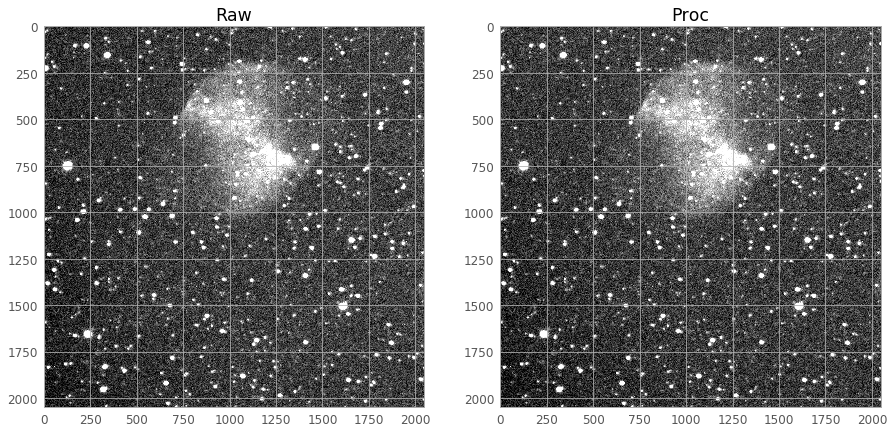

In [27]:
# set up the figure environment
plt.figure()
f,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,15))

# vic1: show image, circle asteroid
ax[0].set_title('Raw')
p2, p98 = np.percentile(sci_im, (2, 98))
sci_im_rescal = exposure.rescale_intensity(sci_im, in_range=(p2, p98))
ax[0].imshow(sci_im_rescal, cmap='gray')

# win1: show image, circle asteroid
ax[1].set_title('Proc')
p2, p98 = np.percentile(sci_im_f, (2, 98))
sci_im_f_rescal = exposure.rescale_intensity(sci_im_f, in_range=(p2, p98))
ax[1].imshow(sci_im_f_rescal, cmap='gray')

plt.show()

## TAKE HOME PART:

On the processed image, run photometry on the stars. Use the method we used in the Star Counts lab to do these steps. You may copy and paste the required code and change the names of variables as needed. 

#### **IT IS IMPORTANT TO UNDERSTAND WHAT IS GOING ON IN EACH STEP**

    1. Start with Step 3, Choose a sub-region
    2. Do all the succeeding steps to estimate the optimal aperture and measure the flux. 
    3. In Step 8, to convert flux to magnitude, use a zero point, ZP = 15.
    4. Complete Step 9, with estimating and plotting the luminosity function.
    5. You do not have to do the remaining steps (fitting the slope)

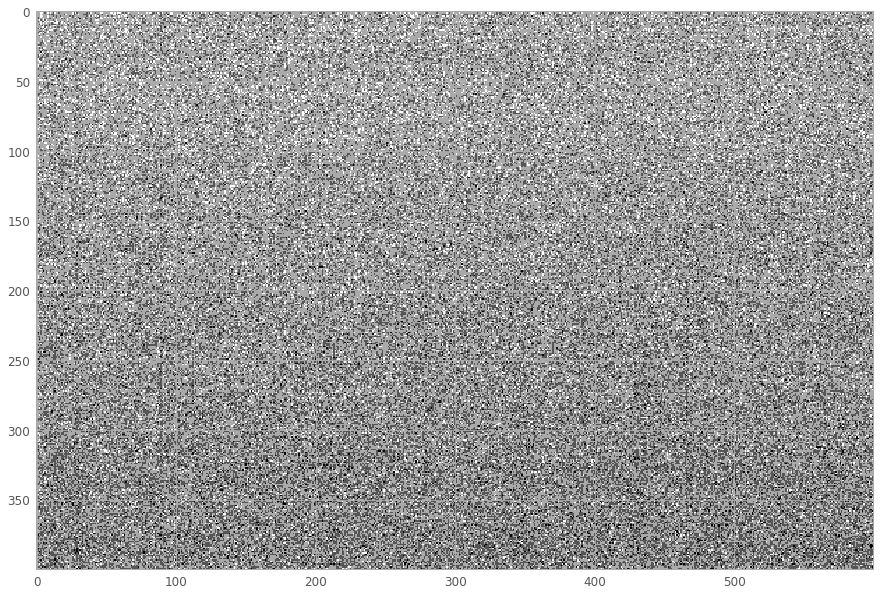

In [28]:
# Choose the row and column range of your chosen sub-region. 
# Use the format "image_region = image_data[row1:row2,col1:col2]"
image_region = master_bias[400:800,600:1200]  #ENTER VALUE

# Make a copy of your subregion that is rescaled for better contrast.
p2, p98 = np.percentile(image_region, (2, 98))
region_rescale = skimage.exposure.rescale_intensity(image_region, in_range=(p2, p98))

# display the image using an inverted greyscale colormap
plt.figure(figsize=(15,30))
plt.imshow(region_rescale, cmap='gray_r')
plt.grid(True)  # plots gridlines to help read axes

In [30]:
# measure basic statistics in the sub-region
mean = np.mean(master_bias)
median = np.median(master_bias)
stddev = np.std(master_bias)
print('Statistics from raw image:' \
      +' mean = %.2f, median = %.2f, stddev = %.2f' %(mean,median,stddev))

# use the sigma-clipping algorithm to reject outliers
sc_mean, sc_median, sc_stddev = sigma_clipped_stats(image_region, sigma=5.0, maxiters=5)

print('Statistics after sigma-clipping: ' \
      +' mean = %.2f, median = %.2f, stddev = %.2f' %(sc_mean,sc_median,sc_stddev))

Statistics from raw image: mean = 642.65, median = 643.00, stddev = 1.07
Statistics after sigma-clipping:  mean = 642.26, median = 642.00, stddev = 0.66


In [31]:
# set approximate approximate fwhm to use for aperture, 
# then use daofind to locate bright stars in the subregion

approx_fwhm = 5 # pixels
threshold = 20.*sc_stddev
daofind = photutils.DAOStarFinder(fwhm=approx_fwhm, threshold=threshold) 
sources = daofind(image_region - sc_median) # find sources in the sky-subtracted image

# print out source data as a table
for colname in sources.colnames:
    sources[colname].info.format = '%.3f' 
print(sources)

# plot the subregion, and circle the bright stars found by daofind
plt.figure(figsize=(15,30))
plt.imshow(region_rescale, cmap='gray_r')
plt.plot(sources['xcentroid'], sources['ycentroid'], \
         ls='',marker='o',mec='r',mfc='none',mew=4,ms=24)

AttributeError: 'NoneType' object has no attribute 'colnames'

In [32]:
# choose a bright, unsaturated star (specify by its ID number)
star_id =  14  # ENTER VALUE
star_num = star_id - 1 # because python counts from 0 but the table counts from 1
position = [(sources['xcentroid'][star_num], sources['ycentroid'][star_num])]

# create a list of apertures of increasing radius
radius_list = range(2,20,2) # min=2pix, max=20pix, step=2
flux_list = [] # an empty list to hold the measured flux in each aperture

for aperture_radius in radius_list:
    apertures = photutils.CircularAperture(position, r=aperture_radius)
    phot_table = photutils.aperture_photometry(image_region-sc_median, apertures)
    flux_value = phot_table['aperture_sum'][0]
    flux_list.append(flux_value)

# convert the flux list into an array, to make math and indexing easier
flux_list = np.array(flux_list)

# plot aperture radius vs measured flux to determine optimal aperture
plt.figure()
plt.plot(radius_list,flux_list,'bo')
plt.title('curve of growth')
plt.xlabel('aperture radius [pix]')
plt.ylabel('total flux [ADU]')
plt.grid(True)  # plots gridlines to help read axes

TypeError: 'NoneType' object is not subscriptable

In [35]:
# set the aperture size and detection threshold 
optimal_aperture = 10 # ENTER VALUE (determined in step 6)
threshold = 3. * sc_stddev # try changing to a different multiple of sc_stddev

# detect sources in the full image
daofind = photutils.DAOStarFinder(fwhm=optimal_aperture, threshold=threshold) 
sources = daofind(master_bias - sc_median) # notice that we are subtracting the sky background

# measure the sources using aperture photometry
positions = (sources['xcentroid'], sources['ycentroid'])
apertures = photutils.CircularAperture(positions, r=optimal_aperture)
phot_table = photutils.aperture_photometry(master_bias - sc_median, apertures)

# print the results in a nicely formatted table
for colname in phot_table.colnames:
    phot_table[colname].info.format = '%.3f'
print(phot_table)

   id    xcenter  ycenter  aperture_sum
           pix      pix                
-------- -------- -------- ------------
   1.000 1983.360   10.559     -186.871
   2.000  761.489   13.692     -188.251
   3.000  941.488   14.726     -196.060
   4.000  970.127   14.835     -181.280
   5.000 1851.222   17.851     -180.533
   6.000 1911.850   17.744     -181.044
   7.000 1716.171   20.047     -192.165
   8.000  850.737   26.924     -203.897
   9.000  175.988   27.803     -213.212
  10.000  510.096   30.321     -195.902
     ...      ...      ...          ...
1398.000 1580.174 2042.051      494.086
1399.000  318.424 2041.395      447.718
1400.000  416.914 2042.109      421.610
1401.000  824.501 2041.968      430.437
1402.000 1018.304 2042.055      425.860
1403.000 1058.932 2041.974      450.092
1404.000 1282.676 2042.058      454.168
1405.000 1452.427 2042.897      408.559
1406.000 1191.111 2042.452      424.792
1407.000 1702.712 2042.702      460.971
Length = 1407 rows


In [36]:
# flux zero point
ZP = 25.

# extract the aperture sum column from the phot table, convert to array
# remove any negative fluxes
aperture_sum = np.array(phot_table['aperture_sum'])
good_aperture_sum = aperture_sum[aperture_sum > 0.]

# calculate magnitudes
log10_flux = np.log10(good_aperture_sum)
apparent_magnitude = -2.5 * log10_flux + ZP

# print data to make sure the negative values were successfully removed
# (formatting yields a nicely readable table)
print('%10s %10s' % ('Flux','Magnitude'))
for a,m in zip(good_aperture_sum, apparent_magnitude):
    print('%10.1f %10.3f' % (a,m))

      Flux  Magnitude
      30.2     21.300
      54.7     20.654
      17.0     21.925
      38.9     21.025
      32.3     21.225
      21.3     21.678
      38.6     21.032
      44.2     20.887
      43.2     20.912
      29.9     21.310
      44.3     20.883
      37.0     21.080
      52.0     20.709
      34.6     21.153
      15.0     22.058
      32.0     21.238
      35.1     21.136
      43.1     20.913
      19.8     21.758
      60.5     20.546
      33.4     21.191
      33.4     21.190
      38.2     21.045
      13.9     22.142
       7.1     22.871
      34.5     21.156
      57.7     20.597
      63.2     20.498
      71.4     20.365
      41.3     20.961
      37.1     21.078
      54.5     20.659
      62.8     20.505
      69.9     20.389
      34.7     21.149
      78.9     20.257
      32.7     21.214
      53.1     20.688
      98.7     20.014
      70.2     20.385
      77.3     20.280
      62.7     20.507
      48.5     20.787
      63.6     20.492
      48.5